# Optimal Approximation Network

The purpose of this notebook is to recreate the numerical experiments done in "Optimal Approximation with Sparsely Connected Deep Neural Networks" by Bölcskei, Grohs, Kutyniok, and Petersen. The authors use an architecture proposed in another paper, "Provable approximation properties for deep neural networks" by Shaham, Cloninger, and Coifman. We will be using Keras to build our network, with a Tensorflow backend.

In [1]:
import numpy as np

# My random numbers generated for seeds. Generated from uniform distribution on integers [0,100]
# 47, 82, 96

# Set seeds for reproducibility.
np.random.seed(82)
from tensorflow import set_random_seed
set_random_seed(82)

import matplotlib.pyplot as plt
from itertools import product
from keras import backend as K #using tensorflow as backend
from keras.models import Sequential
from keras.layers import Dense, Activation

Using TensorFlow backend.


Below, you will find some hyperparameters which determine the topology of our network. Parameters N0, N1, N2, and N3 determine the heights of layers 0 through 3, respectively. NUM_SUBNETs is the number of subnetworks as in Figure 3 (right) of "Optimal Approximation". These smaller subnetworks act as a single bump function, or element in our learned dictionary. 

In [2]:
N0 = 2
NUM_SUBNETS = 45
N1 = 4*NUM_SUBNETS
N2 = NUM_SUBNETS
N3 = 1

Next, we define some supporting functions. The network in "Optimal Approximations" fixes the weights between the first and second layers and learns the remaining weights. This experiment only considers binary classifcation of data with linear and quadratic decision boundaries.

In [3]:
def layer2init(shape, dtype=float):
    """
    Build the *fixed* second layer.
    """
    W = np.zeros(shape, dtype)
    v = np.zeros((shape[0],))
    v[0:4,] = [1,-1,-1,1]
    for i in range(0,shape[1]):
        W[:,i] = np.roll(v,4*i)
    
    return W

def classify(point, func):
    """
    Takes in a tuple point=(x,y) and returns 0 if it lies below the graph of func, and
    1 otherwise.
    """
    x,y = point
    label = 0 if y<=func(x) else 1
    return label

def genGrid(n, func, a=-1, b=1):
    """
    Generates n labelled samples from points on a uniform grid in [a,b]^2. Points below
    the graph of func are classified as 0, whereas those above are classified as 1.
    """
    rng = np.linspace(a,b,n)
    data = [pair for pair in product(rng,rng)]
    return data

def getLargestNets(n, model):
    """
    Returns the indices of n subnetworks in model with the n largest (in modulus) weights
    in the final layer. 
    """
    last_layer = model.layers[-2] # It's the penultimate because Keras counts rectifiers as
                                  # a layer.
    weights = abs(last_layer.get_weights()[0]) # First element because we don't want the bias term.
    indices = weights.flatten().argsort()
    return indices[::-1][0:n]
    
    

Our network uses ReLUs as rectifiers and binary cross-entropy as our loss function. 

In [4]:
model = Sequential([
        Dense(N1, input_shape=(N0,)),
        Activation('relu'),
        Dense(N2, kernel_initializer=layer2init, trainable=False),
        Activation('relu'),
        Dense(N3),
        Activation('relu')    
        ])
        
model.compile(optimizer='sgd',
              loss='mean_squared_error',
              metrics=['binary_accuracy']
              )

## Linear Decision Boundary

In [5]:
#m = 1 # Slope parameter
#b = 0 # Intercept parameter
#n = 50 # Resolution of uniform grid to sample from
#data = genGrid(n, lambda x: m*x+b)
#labels = list(map(lambda x: classify(x, lambda y: m*y+b), data))

# Plot the data
#group0 = np.take(data, [i for i,x in enumerate(labels) if x == 0], axis=0)
#group1 = np.take(data, [i for i,x in enumerate(labels) if x == 1], axis=0)

#fig, ax = plt.subplots()
#ax.scatter(group0[:,0], group0[:,1], color='r', marker='^', alpha=.4)
#ax.scatter(group1[:,0], group1[:,1], color='b', alpha=.4)
#plt.show()

In [6]:
#model.fit(data, labels, epochs=10, batch_size=5)

What's surprising about the experiments in "Optimal Approximation" is that the learned dictionary looks like a wavelet frame. In particular, the graphs in Figure 5 (c)-(f) looks like shearlets. We now visualize what the learned dictionary is.

In [7]:
getLayer2output = K.function([model.layers[0].input],
                                  [model.layers[3].output])

In [8]:
#x,y = zip(*data)
#x = np.array(x)
#x = x.reshape(n,n)
#y = np.array(y)
#y = y.reshape(n,n)
# Visualize on a larger grid.
#N = 10*n
#x = np.linspace(-100,100,N)
#y = np.linspace(-100,100,N)
#big_grid = [prod for prod in product(x,y)]
#linear_output = getLayer2output([big_grid])[0]
#linear_output = getLayer2output([data])[0]

# Visualize the most significant bump functions. Significance is measured by how large the
# weights are, in modulus, in the final layer.
#bump_funcs = getLargestNets(10, model)
#for i in bump_funcs:
#    z = linear_output[:,i].reshape(n,n)
#    fig = plt.figure()
#    plt.contourf(x, y, z)
#plt.show()

## Quadratic Decision Boundary

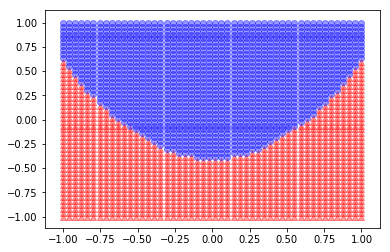

In [9]:
a,b,c = 1, 0, -0.4 # Coefficients of monomials
n = 50 # Resolution of grid
data = genGrid(n, lambda x: a*(x**2)+b*x + c)
labels = list(map(lambda x: classify(x, lambda y: a*(y**2)+b*y + c), data))

# Plot the data
group0 = np.take(data, [i for i,x in enumerate(labels) if x == 0], axis=0)
group1 = np.take(data, [i for i,x in enumerate(labels) if x == 1], axis=0)

fig, ax = plt.subplots()
ax.scatter(group0[:,0], group0[:,1], color='r', marker='^', alpha=.4)
ax.scatter(group1[:,0], group1[:,1], color='b', alpha=.4)
plt.show()

In [10]:
model.fit(data, labels, epochs=10, batch_size=10)

Epoch 1/10
2500/2500 [==============================] - 0s - loss: 0.1215 - binary_accuracy: 0.8388     
Epoch 2/10
2500/2500 [==============================] - 0s - loss: 0.0646 - binary_accuracy: 0.9204     
Epoch 3/10
2500/2500 [==============================] - 0s - loss: 0.0566 - binary_accuracy: 0.9340     
Epoch 4/10
2500/2500 [==============================] - 0s - loss: 0.0511 - binary_accuracy: 0.9464     
Epoch 5/10
2500/2500 [==============================] - 0s - loss: 0.0467 - binary_accuracy: 0.9540     
Epoch 6/10
2500/2500 [==============================] - 0s - loss: 0.0435 - binary_accuracy: 0.9612     
Epoch 7/10
2500/2500 [==============================] - 0s - loss: 0.0405 - binary_accuracy: 0.9680     
Epoch 8/10
2500/2500 [==============================] - 0s - loss: 0.0385 - binary_accuracy: 0.9676     
Epoch 9/10
2500/2500 [==============================] - 0s - loss: 0.0365 - binary_accuracy: 0.9716     
Epoch 10/10
2500/2500 [==============================] 

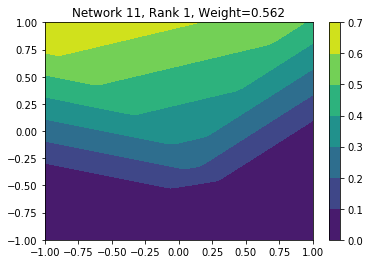

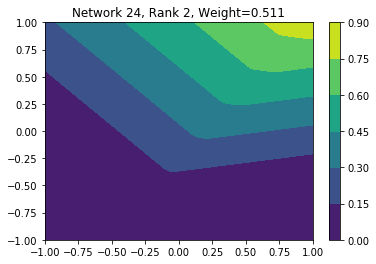

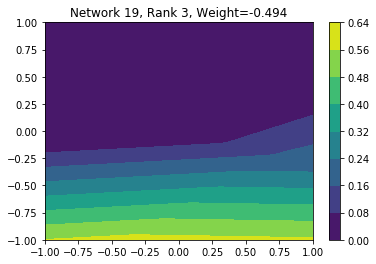

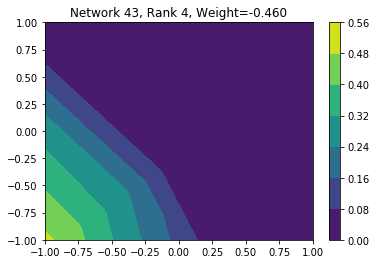

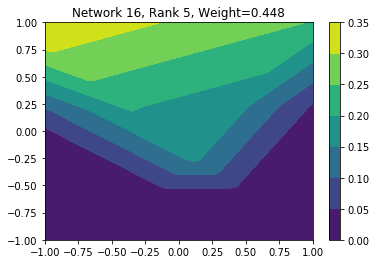

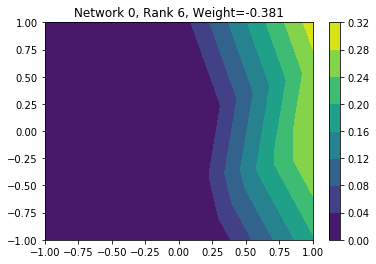

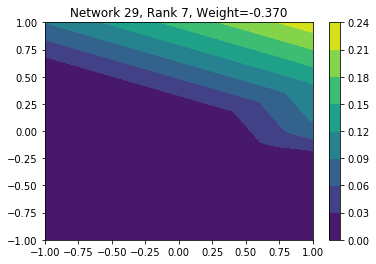

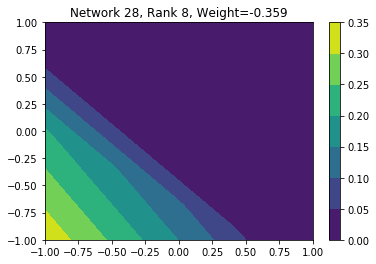

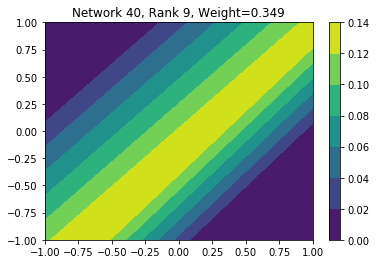

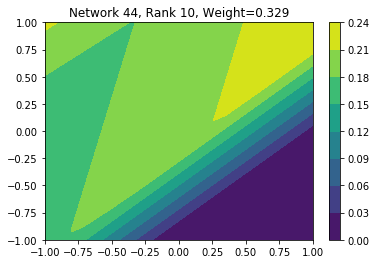

In [12]:
x,y = zip(*data)
x = np.array(x)
x = x.reshape(n,n)
y = np.array(y)
y = y.reshape(n,n)

quad_output = getLayer2output([data])[0]
bump_funcs = getLargestNets(10, model) #np.arange(150, 200) 
for j, idx in enumerate(bump_funcs):
    z = quad_output[:,idx].reshape(n,n)
    fig = plt.figure()
    cp = plt.contourf(x, y, z)
    plt.colorbar(cp)
    plt.title("Network {}, Rank {}, Weight={:.3f}".format(idx, j+1,model.layers[-2].get_weights()[0][idx][0]))
    #if (j+1)==2:
    #    plt.savefig("ex45_82_82_2.png")
plt.show()

Author's notes:

### Quadratic Decision Boundary for f(x) = x^2 - 0.4

|NUM_SUBNETS | Numpy Seed | Tensorflow Seed | Notable Shearlet Looking Networks, by Rank|
|:----------:|:-----------:|:----------------:|-----------------:|
|15          |     47      |         47       | 2, 4, 8, 9, 10 | 
|15          |     47      |         82       | 9, 10 |
|15          |     47      |         96       | Unremarkable | 
|15          |     82      |         47       | 2, 3, 10  | 
|15          |     82      |         82       | Unremarkable | 
|15          |     82      |         96       | 2, 3, 7, 8 | 
|15          |     96      |         47       | 3, 4, 7 | 
|15          |     96      |         82       | 3, 6  | 
|15          |     96      |         96       | Accuracy < 0.5  | 
|30          |     47      |         47       | 3, 7 | 
|30          |     47      |         82       | 4, 5, 7 |
|30          |     47      |         96       | 3, 5, 6, 8 | 
|30          |     82      |         47       | 2 | 
|30          |     82      |         82       | 1, 5 (almost) | 
|30          |     82      |         96       | 7 | 
|30          |     96      |         47       | 1, 3, 8 | 
|30          |     96      |         82       | Unremarkable | 
|30          |     96      |         96       | 6 | 
|45          |     47      |         47       | 7 | 
|45          |     47      |         82       | Unremarkable |
|45          |     47      |         96       | Unremarkable | 
|45          |     82      |         47       | 1, 3, 5, 7| 
|45          |     82      |         82       | 9, 10| 
|45          |     82      |         96       | 5 | 
|45          |     96      |         47       | 6, 8 | 
|45          |     96      |         82       | 2, 4 | 
|45          |     96      |         96       | Accuracy < 0.5 | 
